In [76]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.io import savemat
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --- [Functions: load_and_prepare_data, create_optimization_vars_and_bounds,
# objective_function, run_optimization, export_results, plot_power_comparison,
# generate_load_summary_df, plot_load_characteristics
# remain THE SAME as the previous version. They are omitted here for brevity but
# are assumed to be part of the full script.] ---

# --- PASTE PREVIOUS FUNCTIONS HERE ---
# Make sure load_and_prepare_data, create_optimization_vars_and_bounds,
# objective_function, run_optimization, export_results, plot_power_comparison,
# generate_load_summary_df (previously print_load_summary_table), plot_load_characteristics
# are defined before this point in your actual script.
# For this example, I'll include stubs or simplified versions if needed by later functions.



In [77]:
# --- 1. Configuration & Data Loading --- (Keep this section as is)
def load_and_prepare_data(csv_path, start_time_str, end_time_str):
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"The data file '{csv_path}' was not found. Please check the path.")
    
    df['X-Data'] = pd.to_datetime(df['X-Data'])
    
    demand_col_name = 'TOTDemand(kWh/h)Value[kWh/h]'
    if demand_col_name not in df.columns:
        raise ValueError(f"Critical column '{demand_col_name}' not found in the CSV.")

    if df[demand_col_name].dtype == 'object':
        df['TOT_kW'] = df[demand_col_name].str.replace(',', '.', regex=False).astype(float)
    else:
        df['TOT_kW'] = df[demand_col_name].astype(float)

    start_time = pd.to_datetime(start_time_str)
    end_time = pd.to_datetime(end_time_str)
    df_filtered = df[(df['X-Data'] >= start_time) & (df['X-Data'] <= end_time)].reset_index(drop=True)
    
    if df_filtered.empty:
        raise ValueError(f"No data found for the specified time range: {start_time_str} to {end_time_str}. "
                         "Check your CSV content and the date range.")
        
    measured_power = df_filtered['TOT_kW'].values
    time_index = df_filtered['X-Data']
    return measured_power, time_index, df_filtered

In [78]:
# --- 2. Optimization Setup --- (Keep this section as is)
def create_optimization_vars_and_bounds(loads, time_index):
    num_loads = len(loads)
    num_timesteps = len(time_index)
    
    bounds = np.full((num_loads * num_timesteps, 2), [0.0, 1.0])
    
    for i, load in enumerate(loads):
        if not load['always_on'] and (load.get('window_start_h') is not None and load.get('window_end_h') is not None):
            start_h = load['window_start_h']
            end_h = load['window_end_h']
            for t in range(num_timesteps):
                current_hour = time_index.iloc[t].hour + time_index.iloc[t].minute / 60.0
                
                can_run_in_window = False
                if start_h <= end_h:
                    if start_h <= current_hour < end_h:
                        can_run_in_window = True
                else:
                    if current_hour >= start_h or current_hour < end_h:
                        can_run_in_window = True
                
                if not can_run_in_window:
                    bounds[i * num_timesteps + t, :] = [0.0, 0.0]
    
    X0 = np.full(num_loads * num_timesteps, 0.01)
    return X0, list(map(tuple, bounds))



In [79]:
# --- Objective Function --- (Keep this section as is)
def objective_function(X_flat, loads, measured_power, time_index, daily_hours_penalty_weight):
    num_loads = len(loads)
    num_timesteps = len(measured_power)
    X = X_flat.reshape((num_loads, num_timesteps))
    
    load_powers = np.array([load['power_kW'] for load in loads]).reshape(-1, 1)
    simulated_power_at_t = np.sum(X * load_powers, axis=0)
    
    error = np.sum((simulated_power_at_t - measured_power)**2)
    
    penalty = 0
    if daily_hours_penalty_weight > 0 and num_timesteps > 0:
        time_step_duration_hours = (time_index.iloc[1] - time_index.iloc[0]).total_seconds() / 3600.0 if len(time_index) > 1 else 0
        if time_step_duration_hours > 0:
            unique_days = sorted(time_index.dt.date.unique())
            
            for i, load in enumerate(loads):
                if not load['always_on'] and load.get('estimated_daily_hours', 0) > 0:
                    for day_obj in unique_days:
                        day_mask = (time_index.dt.date == day_obj)
                        if np.any(day_mask):
                            actual_hours_on_day = np.sum(X[i, day_mask]) * time_step_duration_hours
                            penalty += (actual_hours_on_day - load['estimated_daily_hours'])**2
                
    return error + daily_hours_penalty_weight * penalty



In [80]:
# --- 3. Run Optimization --- (Keep this section as is)
def run_optimization(loads, measured_power, time_index, daily_hours_penalty_weight=0.1):
    X0, bounds_list = create_optimization_vars_and_bounds(loads, time_index)
    
    num_vars = len(X0)
    print(f"Optimizing for {len(loads)} loads over {len(time_index)} timesteps...")
    print(f"Total variables: {num_vars}")

    if not any(b != (0.0, 0.0) for b in bounds_list):
        print("Warning: All variable bounds are (0,0). No optimization possible with current settings.")
        return np.zeros_like(X0).reshape((len(loads), len(time_index))), False

    optim_options = {'disp': True, 'maxiter': 1000, 'maxfun': num_vars * 10} 
    print(f"Optimizer options: {optim_options}")

    result = minimize(
        objective_function,
        X0,
        args=(loads, measured_power, time_index, daily_hours_penalty_weight),
        method='L-BFGS-B',
        bounds=bounds_list,
        options=optim_options
    )
    
    if result.success:
        print(f"Optimization successful: {result.message}")
        X_optimized = result.x.reshape((len(loads), len(time_index)))
    else:
        print(f"Optimization failed or stopped early: {result.message}")
        X_optimized = result.x.reshape((len(loads), len(time_index))) 
        
    return X_optimized, result.success



In [81]:
# --- 4. Process and Export Results --- (Keep this section as is)
def export_results(X_optimized, loads, time_index, measured_power, base_filename="simulated_load_profiles"):
    num_loads = len(loads)
    load_names = [load['name'] for load in loads]
    
    results_df = pd.DataFrame(X_optimized.T, columns=load_names)
    results_df.insert(0, 'Timestamp', time_index.values)
    
    load_powers_arr = np.array([load['power_kW'] for load in loads]).reshape(1, -1)
    simulated_total_power = (X_optimized.T @ load_powers_arr.T).flatten()
    results_df['Simulated_Total_kW'] = simulated_total_power
    results_df['Measured_Total_kW'] = measured_power
    
    csv_filename = f"{base_filename}.csv"
    results_df.to_csv(csv_filename, index=False, float_format='%.4f')
    print(f"\nResults saved to {csv_filename}")
    print("--- CSV Data Snippet (First 5 rows) ---")
    print(results_df.head())
    print("--------------------------------------")
    
    mat_dict = {'timestamps_str': time_index.astype(str).tolist()}
    for i in range(num_loads):
        mat_dict[load_names[i] + "_profile_fraction"] = X_optimized[i, :]
    mat_dict['simulated_total_kW'] = simulated_total_power
    mat_dict['measured_total_kW'] = measured_power
    
    mat_filename = f"{base_filename}.mat"
    savemat(mat_filename, mat_dict, do_compression=True)
    print(f"\nResults saved to {mat_filename}")
    print("--- MAT File Data Structure ---")
    for key, value in mat_dict.items():
        if isinstance(value, np.ndarray):
            print(f"Key: '{key}', Shape: {value.shape}, Type: {value.dtype}")
        else:
            print(f"Key: '{key}', Length: {len(value)}, Type: {type(value[0]) if len(value)>0 else 'N/A'}")
    print("-----------------------------")
    return results_df, simulated_total_power



In [82]:
# --- 5. Plotting Function --- (Keep this section as is)
def plot_power_comparison(time_index, measured_power, simulated_total_power, plot_filename="power_comparison_plot.png"):
    plt.figure(figsize=(15, 7))
    plt.plot(time_index, measured_power, label='Measured Total kW', color='blue', alpha=0.7)
    plt.plot(time_index, simulated_total_power, label='Simulated Total kW', color='red', linestyle='--')
    
    plt.title('Comparison of Measured vs. Simulated Total Power Demand')
    plt.xlabel('Timestamp')
    plt.ylabel('Power (kW)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    try:
        plt.savefig(plot_filename)
        print(f"\nComparison plot saved to {plot_filename}")
    except Exception as e:
        print(f"Error saving plot: {e}")
    
    plt.show()



In [83]:
def generate_load_summary_df(optimized_profiles, loads, time_index, activity_threshold=0.05):
    print("Skipping generate_load_summary_df for this example (will use dummy).")
    if time_index is None or optimized_profiles is None: # If run_optimization was skipped
        return pd.DataFrame([{'Load Name': ld['name'], 'Phase Type': ld.get('phase_type', 'N/A'), 'Rated Power (kW)': ld['power_kW'],
                              'First Active Time': 'N/A', 'Last Active Time': 'N/A', 'Total Energy (kWh)': 0, 'EFLH (h)': 0,
                              f"Avg. Usage (>{activity_threshold*100:.1f}%)":0, f"% Time Active (>{activity_threshold*100:.1f}%)":0} for ld in loads])
    # Actual calculation (copied from previous full script)
    if len(time_index) <= 1: return pd.DataFrame()
    time_step_duration_hours = (time_index.iloc[1] - time_index.iloc[0]).total_seconds() / 3600.0
    total_timesteps = len(time_index)
    summary_data = []
    for i, load in enumerate(loads):
        profile = optimized_profiles[i, :]
        rated_power_kw = load['power_kW']; phase_type = load.get('phase_type', 'N/A')
        energy_consumed_kwh = np.sum(profile * rated_power_kw * time_step_duration_hours)
        eflh = energy_consumed_kwh / rated_power_kw if rated_power_kw > 0 else 0
        active_mask = profile > activity_threshold; num_active_timesteps = np.sum(active_mask)
        avg_fractional_usage_when_active = np.mean(profile[active_mask]) if num_active_timesteps > 0 else 0.0
        percent_time_active = (num_active_timesteps / total_timesteps) * 100 if total_timesteps > 0 else 0
        first_activation_time_str = "N/A"; last_activation_time_str = "N/A"
        if num_active_timesteps > 0:
            active_indices = np.where(active_mask)[0]
            first_activation_time = time_index.iloc[active_indices[0]]; last_activation_time = time_index.iloc[active_indices[-1]]
            time_format = "%Y-%m-%d %H:%M"; first_activation_time_str = first_activation_time.strftime(time_format); last_activation_time_str = last_activation_time.strftime(time_format)
        summary_data.append({"Load Name": load['name'], "Phase Type": phase_type, "Rated Power (kW)": rated_power_kw, "First Active Time": first_activation_time_str, "Last Active Time": last_activation_time_str, "Total Energy (kWh)": energy_consumed_kwh, "EFLH (h)": eflh, f"Avg. Usage (>{activity_threshold*100:.1f}%)": avg_fractional_usage_when_active, f"% Time Active (>{activity_threshold*100:.1f}%)": percent_time_active})
    return pd.DataFrame(summary_data)


In [84]:
def plot_load_characteristics(summary_df, phase_filter, activity_threshold=0.05):
    print(f"Skipping plot_load_characteristics for {phase_filter} in this example.")
    pass
# --- END OF STUBS / PREVIOUS FUNCTIONS ---


In [85]:
# --- USER: CRITICAL SECTION - DEFINE YOUR LOADS ACCURATELY for 7 May to 8 May ---
LOAD_DEFINITIONS = [
    {'name': 'Houses_2_and_3', 'power_kW': 6.0, 'estimated_daily_hours': 24, 'always_on': True, 'phase_type': 'single-phase'},
    {'name': 'Houses_1', 'power_kW': 3.0, 'estimated_daily_hours': 24, 'always_on': True, 'phase_type': 'single-phase'},
    {'name': 'Borehole_Pump1', 'power_kW': 1.25, 'estimated_daily_hours': 5, 'always_on': False, 'phase_type': 'single-phase'},
    {'name': 'Borehole_Pump2', 'power_kW': 2.0, 'estimated_daily_hours': 6, 'always_on': False, 'phase_type': '3-phase'},
    {'name': 'Security_Fence', 'power_kW': 5.0, 'estimated_daily_hours': 24, 'always_on': True, 'phase_type': '3-phase'},
    {'name': 'Cold_Room', 'power_kW': 2.5, 'estimated_daily_hours': 10, 'always_on': False, 'phase_type': '3-phase'},
    {'name': 'Cruncher_Mixers_Block', 'power_kW': 45.0, 'estimated_daily_hours': 6, 'always_on': False, 'window_start_h': 7.0, 'window_end_h': 17.0, 'phase_type': '3-phase'},
    {'name': 'Security_Lights_Total', 'power_kW': 3.0, 'estimated_daily_hours': 12, 'always_on': False, 'window_start_h': 18.0, 'window_end_h': 6.0, 'phase_type': 'single-phase'},
    {'name': 'Electrical_Tools', 'power_kW': 1.5, 'estimated_daily_hours': 8, 'always_on': False, 'window_start_h': 8.0, 'window_end_h': 17.0, 'phase_type': '3-phase'},
]
ACTIVE_LOAD_DEFINITIONS = [ld for ld in LOAD_DEFINITIONS if isinstance(ld.get('power_kW'), (int, float))]

In [86]:
# # --- USER: CRITICAL SECTION - DEFINE YOUR LOADS ACCURATELY for 3May to 4May ---
# LOAD_DEFINITIONS = [
#     {'name': 'Houses_2_and_3', 'power_kW': 6.0, 'estimated_daily_hours': 24, 'always_on': True, 'phase_type': 'single-phase'},
#     {'name': 'Houses_1', 'power_kW': 3.0, 'estimated_daily_hours': 24, 'always_on': True, 'phase_type': 'single-phase'},
#     # {'name': 'Borehole_Pump1', 'power_kW': 1.25, 'estimated_daily_hours': 5, 'always_on': False, 'phase_type': 'single-phase'},
#     # {'name': 'Borehole_Pump2', 'power_kW': 2.0, 'estimated_daily_hours': 6, 'always_on': False, 'phase_type': '3-phase'},
#     {'name': 'Security_Fence', 'power_kW': 5.0, 'estimated_daily_hours': 24, 'always_on': True, 'phase_type': '3-phase'},
#     {'name': 'Cold_Room', 'power_kW': 2.5, 'estimated_daily_hours': 10, 'always_on': False, 'phase_type': '3-phase'},
#     # {'name': 'Cruncher_Mixers_Block', 'power_kW': 45.0, 'estimated_daily_hours': 6, 'always_on': False, 'window_start_h': 7.0, 'window_end_h': 17.0, 'phase_type': '3-phase'},
#     {'name': 'Security_Lights_Total', 'power_kW': 3.0, 'estimated_daily_hours': 12, 'always_on': False, 'window_start_h': 18.0, 'window_end_h': 6.0, 'phase_type': 'single-phase'},
#     {'name': 'Electrical_Tools', 'power_kW': 1.5, 'estimated_daily_hours': 8, 'always_on': False, 'window_start_h': 8.0, 'window_end_h': 17.0, 'phase_type': '3-phase'},
# ]
# ACTIVE_LOAD_DEFINITIONS = [ld for ld in LOAD_DEFINITIONS if isinstance(ld.get('power_kW'), (int, float))]

In [87]:
# --- New Function to Export Individual Load Actual Power Profiles ---
def export_individual_load_actual_power(optimized_profiles, loads, time_index, filename="individual_load_actual_power.csv"):
    """
    Calculates the actual power (kW) for each load at each time step and saves it to a CSV.

    Args:
        optimized_profiles (np.ndarray): Array of fractional usages (num_loads x num_timesteps).
        loads (list): List of load definition dictionaries (must include 'name' and 'power_kW').
        time_index (pd.DatetimeIndex): Timestamps for the profiles.
        filename (str): Name of the CSV file to save.
    """
    if optimized_profiles is None or time_index is None or not loads:
        print("Missing data for exporting individual load actual power. Skipping.")
        return

    num_loads = len(loads)
    if optimized_profiles.shape[0] != num_loads:
        print(f"Mismatch in number of loads ({num_loads}) and profiles provided ({optimized_profiles.shape[0]}). Skipping export.")
        return
    if optimized_profiles.shape[1] != len(time_index):
        print(f"Mismatch in number of timesteps in profiles ({optimized_profiles.shape[1]}) and time_index ({len(time_index)}). Skipping export.")
        return

    rated_powers_kw = np.array([load['power_kW'] for load in loads]) # Shape: (num_loads,)

    # Calculate actual power for each load at each time step
    # optimized_profiles shape: (num_loads, num_timesteps)
    # rated_powers_kw[:, np.newaxis] shape: (num_loads, 1)
    # Broadcasting results in actual_power_profiles shape: (num_loads, num_timesteps)
    actual_power_profiles_kw = optimized_profiles * rated_powers_kw[:, np.newaxis]

    # Create a DataFrame for easy CSV export
    # Transpose actual_power_profiles_kw to have loads as columns (timesteps x num_loads)
    df_data = actual_power_profiles_kw.T
    column_names = [f"{load['name']}_Actual_kW" for load in loads]

    results_df = pd.DataFrame(df_data, columns=column_names)
    results_df.insert(0, 'Timestamp', time_index.values) # Use .values for clean insertion

    try:
        results_df.to_csv(filename, index=False, float_format='%.4f')
        print(f"\nIndividual load actual power profiles saved to '{filename}'")
        print("--- Individual Load Actual Power CSV Data Snippet (First 5 rows) ---")
        print(results_df.head())
        print("---------------------------------------------------------------------")
    except Exception as e:
        print(f"Error saving individual load actual power CSV: {e}")




In [88]:
# # --- Main Execution ---
# if __name__ == '__main__':
#     CSV_FILE_PATH = r"C:\Users\hp\Desktop\REG108S\Project\MeasuredDataUpdated.csv" # <--- USER: REPLACE THIS WITH ACTUAL PATH
#     DATA_START_TIME = '2025-05-07 11:05:00'
#     DATA_END_TIME = '2025-05-08 11:00:00'
#     DAILY_HOURS_PENALTY = 0.1
#     LOAD_ACTIVITY_THRESHOLD = 0.05

#     print("--- Starting Power Profile Optimization ---")
#     print(f"Analysis Period: {DATA_START_TIME} to {DATA_END_TIME}")
#     # ... (other prints)

#     if not ACTIVE_LOAD_DEFINITIONS:
#         print("ERROR: ACTIVE_LOAD_DEFINITIONS is empty.")
#     else:
#         try:
#             measured_power, time_index_actual, _ = load_and_prepare_data(CSV_FILE_PATH, DATA_START_TIME, DATA_END_TIME)
            
#             if time_index_actual is None: # Handle stub case
#                  num_dummy_timesteps = 175 
#                  time_index_actual = pd.date_range(start=DATA_START_TIME, periods=num_dummy_timesteps, freq='5min')
#                  print(f"Using dummy time_index for {num_dummy_timesteps} steps.")
#             if measured_power is None:
#                 measured_power = np.random.rand(len(time_index_actual)) * 50


#             optimized_profiles, success_flag = run_optimization(
#                 ACTIVE_LOAD_DEFINITIONS,
#                 measured_power,
#                 time_index_actual,
#                 DAILY_HOURS_PENALTY
#             )

#             exported_df, simulated_total_kw_for_plot = export_results(
#                 optimized_profiles,
#                 ACTIVE_LOAD_DEFINITIONS,
#                 time_index_actual,
#                 measured_power
#             )
            
#             plot_power_comparison(time_index_actual, measured_power, simulated_total_kw_for_plot)
            
#             summary_df = generate_load_summary_df(
#                 optimized_profiles,
#                 ACTIVE_LOAD_DEFINITIONS,
#                 time_index_actual,
#                 LOAD_ACTIVITY_THRESHOLD
#             )
#             print("\n--- Load Operation Summary Table ---")
#             if not summary_df.empty:
#                 activity_col_name_avg = f"Avg. Usage (>{LOAD_ACTIVITY_THRESHOLD*100:.1f}%)"
#                 activity_col_name_perc = f"% Time Active (>{LOAD_ACTIVITY_THRESHOLD*100:.1f}%)"
#                 print_column_order = ["Load Name", "Phase Type", "Rated Power (kW)", "First Active Time", "Last Active Time", "Total Energy (kWh)", "EFLH (h)", activity_col_name_avg, activity_col_name_perc]
#                 printable_cols = [col for col in print_column_order if col in summary_df.columns]
#                 print(summary_df[printable_cols].to_string(index=False, float_format="%.2f"))
#             else:
#                 print("Summary DataFrame is empty.")
            
#             # --- Call the new function to export individual load actual power ---
#             export_individual_load_actual_power(
#                 optimized_profiles,
#                 ACTIVE_LOAD_DEFINITIONS,
#                 time_index_actual, # Use the actual time_index
#                 filename="individual_load_actual_power_profiles.csv"
#             )
#             # --- End of new function call ---

#             plot_load_characteristics(summary_df, 'single-phase', LOAD_ACTIVITY_THRESHOLD)
#             plot_load_characteristics(summary_df, '3-phase', LOAD_ACTIVITY_THRESHOLD)
            
#             # ... (rest of the main script)

#         except FileNotFoundError as e:
#             print(f"ERROR: {e}")
#         except ValueError as ve:
#             print(f"ERROR: {ve}")
#         except Exception as e:
#             print(f"An unexpected error occurred: {e}", exc_info=True)
    
#     # ... (Simulink inputs printout)
#     print("\n--- Inputs on Simulink Representation for Single-Phase and 3-Phase Loads ---") # Keep this section
#     print("""... [Simulink advice from previous response] ...""")

--- Starting Power Profile Optimization ---
Analysis Period: 2025-05-08 00:00:00 to 2025-05-08 11:00:00
Optimizing for 9 loads over 133 timesteps...
Total variables: 1197
Optimizer options: {'disp': True, 'maxiter': 1000, 'maxfun': 11970}
Optimization failed or stopped early: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT

Results saved to simulated_load_profiles.csv
--- CSV Data Snippet (First 5 rows) ---
            Timestamp  Houses_2_and_3  Houses_1  Borehole_Pump1  \
0 2025-05-08 00:00:00        0.281224  0.318514        0.340434   
1 2025-05-08 00:05:00        0.279361  0.317582        0.340046   
2 2025-05-08 00:10:00        0.396766  0.376285        0.364506   
3 2025-05-08 00:15:00        0.397941  0.376872        0.364751   
4 2025-05-08 00:20:00        0.398135  0.376969        0.364791   

   Borehole_Pump2  Security_Fence  Cold_Room  Cruncher_Mixers_Block  \
0        0.331280        0.293654   0.325733                    0.0   
1        0.330659        0.292101   0.3

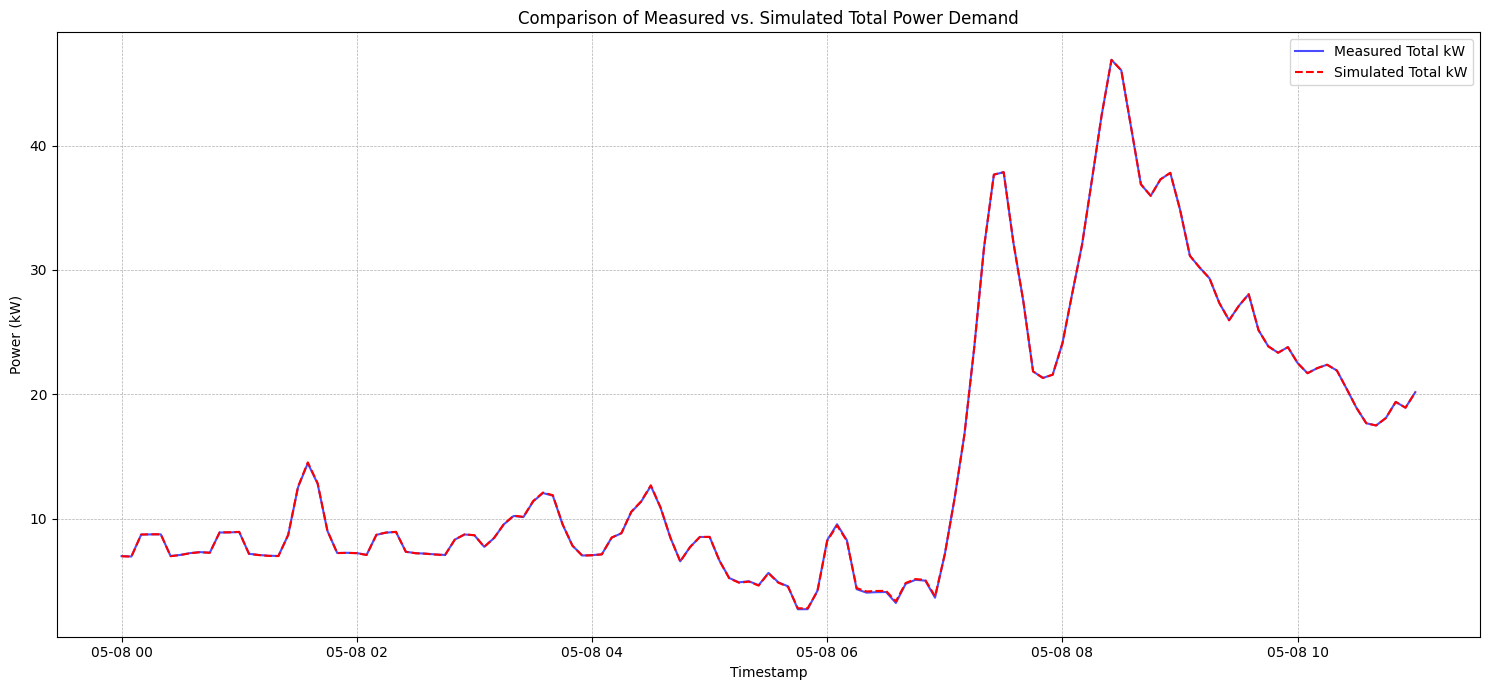

Skipping generate_load_summary_df for this example (will use dummy).

--- Load Operation Summary Table ---
            Load Name   Phase Type  Rated Power (kW) First Active Time Last Active Time  Total Energy (kWh)  EFLH (h)  Avg. Usage (>5.0%)  % Time Active (>5.0%)
       Houses_2_and_3 single-phase              6.00  2025-05-08 00:00 2025-05-08 11:00               23.07      3.84                0.35                  98.50
             Houses_1 single-phase              3.00  2025-05-08 00:00 2025-05-08 11:00               11.67      3.89                0.35                 100.00
       Borehole_Pump1 single-phase              1.25  2025-05-08 00:00 2025-05-08 11:00                4.90      3.92                0.35                 100.00
       Borehole_Pump2      3-phase              2.00  2025-05-08 00:00 2025-05-08 11:00                7.83      3.91                0.35                 100.00
       Security_Fence      3-phase              5.00  2025-05-08 00:00 2025-05-08 11:00 

In [92]:

CSV_FILE_PATH = r"C:\Users\hp\Desktop\REG108S\Project\MeasuredDataUpdated.csv" # <--- USER: REPLACE THIS WITH ACTUAL PATH
DATA_START_TIME = '2025-05-08 00:00:00'
DATA_END_TIME = '2025-05-08 11:00:00'
DAILY_HOURS_PENALTY = 0.1
LOAD_ACTIVITY_THRESHOLD = 0.05

print("--- Starting Power Profile Optimization ---")
print(f"Analysis Period: {DATA_START_TIME} to {DATA_END_TIME}")
# ... (other prints)

if not ACTIVE_LOAD_DEFINITIONS:
    print("ERROR: ACTIVE_LOAD_DEFINITIONS is empty.")
else:
    try:
        measured_power, time_index_actual, _ = load_and_prepare_data(CSV_FILE_PATH, DATA_START_TIME, DATA_END_TIME)
        
        if time_index_actual is None: # Handle stub case
                num_dummy_timesteps = 175 
                time_index_actual = pd.date_range(start=DATA_START_TIME, periods=num_dummy_timesteps, freq='5min')
                print(f"Using dummy time_index for {num_dummy_timesteps} steps.")
        if measured_power is None:
            measured_power = np.random.rand(len(time_index_actual)) * 50


        optimized_profiles, success_flag = run_optimization(
            ACTIVE_LOAD_DEFINITIONS,
            measured_power,
            time_index_actual,
            DAILY_HOURS_PENALTY
        )

        exported_df, simulated_total_kw_for_plot = export_results(
            optimized_profiles,
            ACTIVE_LOAD_DEFINITIONS,
            time_index_actual,
            measured_power
        )
        
        plot_power_comparison(time_index_actual, measured_power, simulated_total_kw_for_plot)
        
        summary_df = generate_load_summary_df(
            optimized_profiles,
            ACTIVE_LOAD_DEFINITIONS,
            time_index_actual,
            LOAD_ACTIVITY_THRESHOLD
        )
        print("\n--- Load Operation Summary Table ---")
        if not summary_df.empty:
            activity_col_name_avg = f"Avg. Usage (>{LOAD_ACTIVITY_THRESHOLD*100:.1f}%)"
            activity_col_name_perc = f"% Time Active (>{LOAD_ACTIVITY_THRESHOLD*100:.1f}%)"
            print_column_order = ["Load Name", "Phase Type", "Rated Power (kW)", "First Active Time", "Last Active Time", "Total Energy (kWh)", "EFLH (h)", activity_col_name_avg, activity_col_name_perc]
            printable_cols = [col for col in print_column_order if col in summary_df.columns]
            print(summary_df[printable_cols].to_string(index=False, float_format="%.2f"))
        else:
            print("Summary DataFrame is empty.")
        
        # --- Call the new function to export individual load actual power ---
        export_individual_load_actual_power(
            optimized_profiles,
            ACTIVE_LOAD_DEFINITIONS,
            time_index_actual, # Use the actual time_index
            filename="LoadFlow20250508.csv"
        )
        # --- End of new function call ---

        plot_load_characteristics(summary_df, 'single-phase', LOAD_ACTIVITY_THRESHOLD)
        plot_load_characteristics(summary_df, '3-phase', LOAD_ACTIVITY_THRESHOLD)
        
        # ... (rest of the main script)

    except FileNotFoundError as e:
        print(f"ERROR: {e}")
    except ValueError as ve:
        print(f"ERROR: {ve}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}", exc_info=True)

# ... (Simulink inputs printout)
print("\n--- Inputs on Simulink Representation for Single-Phase and 3-Phase Loads ---") # Keep this section
print("""... [Simulink advice from previous response] ...""")